In [ ]:
from scipy.special import result

from DataLoader import  DataLoader

dataloader = DataLoader()
dataloader.load_data(10)

image, mask = dataloader.get_image(1)
images, masks = dataloader[:]
print(images.shape, masks.shape)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from thundersvm import SVC
from sklearn.model_selection import GridSearchCV
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.filters import gabor

In [ ]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# def preprocess(images, masks, scale=0.5):
#     resized_images = []
#     resized_masks = []
# 
#     for img, mask in zip(images, masks):
#         img_resized = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
#         mask_resized = cv2.resize(mask, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
#         resized_images.append(img_resized)
#         resized_masks.append(mask_resized)
# 
#     return resized_images, resized_masks   

def resize(image, mask, scale=0.5):
    img_resized = cv2.resize(image, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
    return img_resized, mask_resized

# image, mask = resize(image, mask)
# plt.imshow(image)
# plt.axis('off')
# plt.show()

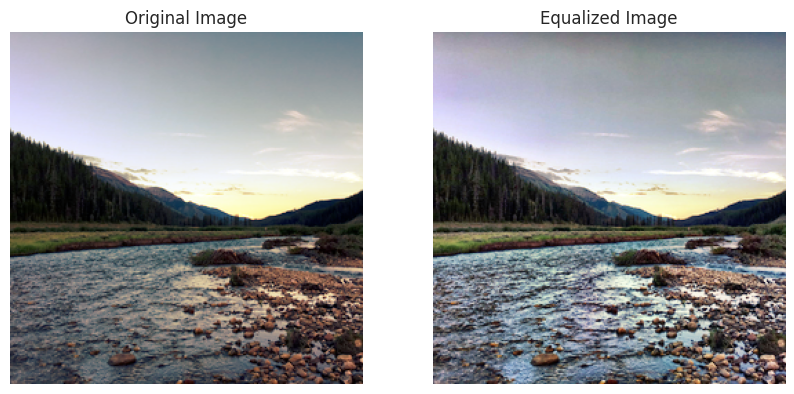

In [210]:
def eq_hist(image, visualize=False):
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(image.shape) == 2:
        result = cv2.equalizeHist(image)
        #result = clahe.apply(image)
    elif len(image.shape) == 3:
        chans = cv2.split(image)
        equalized_chans = [cv2.equalizeHist(chan) for chan in chans]
        #equalized_chans = [clahe.apply(chan) for chan in chans]
        result = cv2.merge(equalized_chans)
        
    if visualize:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(result)
        plt.title("Equalized Image")
        plt.axis("off")
        plt.show()
    return result

image = eq_hist(image, visualize=True)

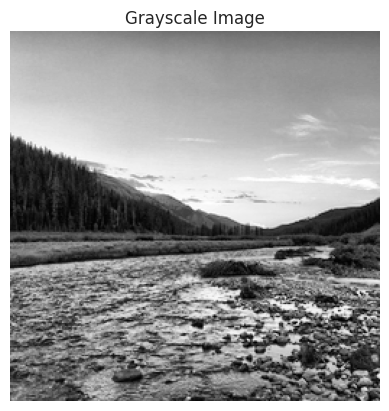

In [211]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()
    return gray

gray = preprocess_image(image)

In [ ]:
def superpixel_segmentation(image, n_segments=80):
    segments = slic(image, n_segments=n_segments, compactness=10, start_label=1, sigma=1)
    segmented_image = label2rgb(segments, image, kind='avg')
    plt.imshow(segmented_image)
    plt.title("Superpixel Segmentation")
    plt.axis('off')
    plt.show()
    return segments

segments = superpixel_segmentation(image)

In [ ]:
def show_hist_segment(image, segments, superpixel_id):
    mask_segment = (segments == superpixel_id).astype("uint8")
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    plt.figure()
    plt.title("'Flattened' Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], mask_segment, [10], [0, 256])
        plt.plot(hist, color=color)
        #plt.xlim([0, 256])
    plt.show()

for id in range(np.max(segments)):
    show_hist_segment(image, segments, id)

In [208]:
def extract_hist(image, segments, superpixel_id):
    mask_segment = (segments == superpixel_id).astype("uint8")
    hist = cv2.calcHist([image], [0,1,2], mask_segment, [8,8,8],  [0, 256, 0, 256, 0, 256])
    return hist

In [209]:
extract_hist(image, segments, 1)

(8, 8, 8)


array([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 

In [ ]:
# def extract_gabor_features(image, gabor_params):
#     print(gabor_params)
#     features = []
#     for frequency in gabor_params['frequency']:
#         for theta in np.linspace(0, np.pi, gabor_params['n_orientations']):
#             print(frequency,theta)
#             real, _ = gabor(image, frequency=frequency, theta=theta)
#             features.append(real)
#     return np.stack(features, axis=-1)

# gabor_responses = extract_gabor_features(gray, {
#     'frequency': [0.1, 0.2, 0.3],  
#     'n_orientations': 8,
# })

In [ ]:
from scipy.ndimage import convolve
from skimage.filters import gabor_kernel

gabor_params = {
    'frequency': 0.1, 'n_orientations': 6
}

# Create a Gabor filter bank with given parameters
gabor_filter_bank = [
    gabor_kernel(frequency=gabor_params['frequency'], theta=theta)
    for theta in np.linspace(0, np.pi, gabor_params['n_orientations'], endpoint=False)
]

def extract_gabor_features(image, gabor_filter_bank):
    responses = []
    
    # Apply each kernel to the image
    for kernel in gabor_filter_bank:
        if image.ndim > 2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        response = convolve(image, np.real(kernel), mode='reflect')  # Apply filter
        responses.append(response)
    
    # Stack responses into a single feature array
    return np.stack(responses, axis=-1)

gabor_responses = extract_gabor_features(gray, gabor_filter_bank)

In [ ]:
for i, gabor in enumerate(gabor_responses.T):
    plt.imshow(gabor)
    plt.title(f"{i+1} channel")
    plt.axis('off')
    plt.show()

In [ ]:
def compute_superpixel_features(segments, gabor_responses):
    num_superpixels = segments.max()
    num_filters = gabor_responses.shape[-1]
    superpixel_features = np.zeros((num_superpixels, num_filters))

    for sp_label in range(1, num_superpixels + 1):
        mask = segments == sp_label
        for f in range(num_filters):
            superpixel_features[sp_label - 1, f] = gabor_responses[..., f][mask].mean()
    
    return superpixel_features

In [ ]:
def get_superpixel_labels_from_mask(segments, ground_truth_labels):
    segments = segments.flatten()
    ground_truth_labels = ground_truth_labels.flatten()
    
    num_superpixels = segments.max()
    superpixel_labels = np.zeros(num_superpixels, dtype=int)

    for sp_label in range(1, num_superpixels + 1):
        # Mask for the current superpixel
        mask = segments == sp_label
        
        # Get the ground-truth labels for the pixels in this superpixel
        pixel_labels = ground_truth_labels[mask]
        
        # Determine the most common label (majority voting)
        if len(pixel_labels) > 0:
            superpixel_labels[sp_label - 1] = np.bincount(pixel_labels).argmax()
        else:
            # Handle edge cases (e.g., superpixel with no pixels)
            superpixel_labels[sp_label - 1] = -1  # or assign a default class, e.g., 0

    return superpixel_labels

def visualize_superpixel_labels(image, segments, ground_truth_labels, superpixel_labels):
    # Overlay superpixel boundaries on the original image
    overlay_image = label2rgb(segments, image, kind='avg')

    # Create a labeled image to show superpixel labels
    labeled_image = np.zeros_like(segments, dtype=int)
    for sp_label in range(1, segments.max() + 1):
        labeled_image[segments == sp_label] = superpixel_labels[sp_label - 1]

    # Plot results
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))

    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(overlay_image)
    ax[1].set_title("Superpixels Overlay")
    ax[1].axis("off")

    ax[2].imshow(labeled_image, cmap="tab20")
    ax[2].set_title("Superpixel Labels")
    ax[2].axis("off")

    ax[3].imshow(ground_truth_labels, cmap="tab20")
    ax[3].set_title("Original Labels")
    ax[3].axis("off")

    plt.tight_layout()
    plt.show()

superpixel_labels = get_superpixel_labels_from_mask(segments, mask)
visualize_superpixel_labels(image, segments, mask, superpixel_labels)

In [ ]:
superpixel_features = compute_superpixel_features(segments, gabor_responses)
superpixel_features.shape

In [ ]:
segments.shape

In [ ]:
image.shape

In [ ]:
def train_svm(features, labels):
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
    svc = SVC()
    grid_search = GridSearchCV(svc, param_grid, cv=3, verbose=2, n_jobs=-1)
    grid_search.fit(features, labels)
    return grid_search.best_estimator_


# svm_features = compute_superpixel_features(segments, gabor_responses)
# svm_labels = get_superpixel_labels_from_mask(segments, mask)
# 
# # Train SVM
# clf = train_svm(svm_features, svm_labels)

In [ ]:
param_grid = {
    # Gabor filter parameters
    "frequency": [0.1, 0.2, 0.3, 0.4],
    "theta": [0, np.pi/4, np.pi/2, 3*np.pi/4],
    "sigma": [1, 2, 3],
    "aspect_ratio": [0.5, 1.0],

    # SVM parameters
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}

In [ ]:
def extract_features_labels(images, masks, gabor_params):
    from skimage.filters import gabor_kernel

    # Create a Gabor filter bank with given parameters
    gabor_filter_bank = [
        gabor_kernel(frequency=gabor_params['frequency'], theta=theta)
        for theta in np.linspace(0, np.pi, gabor_params['n_orientations'], endpoint=False)
    ]
    
    all_features = []
    all_labels = []

    for image, mask in zip(images, masks):
        superpixels = superpixel_segmentation(image)
        gabor_features = extract_gabor_features(image, gabor_filter_bank)
        svm_features = compute_superpixel_features(superpixels, gabor_features)
        svm_labels = get_superpixel_labels_from_mask(superpixels, mask)

        all_features.append(svm_features)
        all_labels.append(svm_labels)

    # Concatenate all features and labels
    all_features = np.vstack(all_features)
    all_labels = np.hstack(all_labels)
    
    return all_features, all_labels

In [ ]:
from sklearn.model_selection import train_test_split, ParameterGrid

# Define the parameter grid for Gabor filters and the SVM
param_grid = {
    'frequency': [0.1, 0.2, 0.3],  # Example frequencies
    'n_orientations': [4, 6, 8],   # Number of Gabor orientations
    'C': [0.1, 1, 10],             # SVM regularization parameter
}

def gabor_svm_pipeline(params, dataloader):
    # Extract features and labels using the current Gabor parameters
    gabor_params = {'frequency': params['frequency'], 'n_orientations': params['n_orientations']}
    images, masks = dataloader[:100]
    images, masks = preprocess(images, masks)
    all_features, all_labels = extract_features_labels(images, masks, gabor_params)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)

    # Train the SVM
    svm = SVC(C=params['C'], kernel='rbf')
    svm.fit(X_train, y_train)

    # Evaluate accuracy
    accuracy = svm.score(X_test, y_test)
    return accuracy, svm

# Perform the grid search
best_score = -np.inf
best_params = None

for params in ParameterGrid(param_grid):
    score, _ = gabor_svm_pipeline(params, dataloader)
    if score > best_score:
        best_score = score
        best_params = params
    print(f'{params}: {score}')

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score:.2f}")

In [ ]:
dataloader.load_data('quarter')
images, masks = dataloader[:]
images, masks = resize(images, masks)
all_features, all_labels = extract_features_labels(images, masks, best_params)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)

# Train the SVM
svm = SVC(C=best_params['C'], kernel='rbf')
svm.fit(X_train, y_train)

# Evaluate accuracy
accuracy = svm.score(X_test, y_test)

In [ ]:
accuracy

In [ ]:
class_names = [
    "Wall",
    "Sky",
    "Tree",
    "Route",
    "Grass",
    "Earth",
    "Mountain",
    "Plant",
    "Water",
    "Sea",
    "Field",
    "Rock",
    "Sand",
    "River",
    "Hill",
    "Land",
    "Waterfall",
]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()